### CIKM paper result for 7 classes (OCR, Zero-shot, and PEFT for LLaVA-Next)
1. final outputs for OCR, LLM Zero-shot, and LoRA LLM, were generated by model_inference.ipynb and stored in final_predictions_class.csv files
2. date: match-based ACC
3. amount: match-based ACC, normalized mean absolute distance
3. the other classes: normalized edit distance


In [15]:
from PIL import Image
import os
import json
from tqdm import tqdm
import pandas as pd
import pandas as pd
import numpy as np


### Amount Class

In [38]:

# Amount: match based ACC
# Note: values should be converted to float. NA value should be replaced by 0.0 

# Load the CSV file
file_path = '/home/larry5/project/LLaVA-1.6-ft/data/cikm/updated_final_predictions_amount.csv'
data_df = pd.read_csv(file_path)

# Function to handle non-convertible values and convert to float
def prepare_float_conversion(df, columns):
    conversion_failures = []
    for col in columns:
        original_data = df[col].copy()
        # Attempt to convert to float with errors set to 'coerce' to handle non-convertible values
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Identify failed conversions by finding rows that turned to NaN
        failed_conversions = df[col].isna() & original_data.notna()
        if failed_conversions.any():
            # Collect only the non-convertible values
            conversion_failures.extend(original_data[failed_conversions].tolist())
        
        # Fill NaN values with 0.0
        df[col].fillna(0.0, inplace=True)
    
    return conversion_failures

# Columns to convert and check
columns_to_check = ['OCR_amount', 'subimage_amount_prediction', 'full_check_amount_prediction', "lora_subimage_amount_prediction", "lora_full_check_amount_prediction", "amount_gt"]

# Handle conversion and log failures
conversion_failures = prepare_float_conversion(data_df, columns_to_check)
# Save the non-convertible values to a CSV file
pd.DataFrame(conversion_failures, columns=['Failed Conversions']).to_csv('/home/larry5/project/LLaVA-1.6-ft/data/test_results/LoRA/amount_convert_failure.csv', index=False)

# Fill any remaining NA values in the DataFrame
data_df.fillna(0.0, inplace=True)

# Function to calculate accuracy based on exact matches
def calculate_accuracy(df, truth_col, pred_cols):
    results = {}
    for col in pred_cols:
        matches = df[truth_col] == df[col]
        accuracy = matches.mean()
        results[col + ' accuracy'] = accuracy
    return results

# Calculate accuracies
accuracies = calculate_accuracy(data_df, 'amount_gt', columns_to_check[:-1])

# Print the accuracy results
for key, value in accuracies.items():
    print(f"{key}: {value:.2%}")


OCR_amount accuracy: 49.21%
subimage_amount_prediction accuracy: 43.65%
full_check_amount_prediction accuracy: 69.44%
lora_subimage_amount_prediction accuracy: 80.16%
lora_full_check_amount_prediction accuracy: 89.68%


/tmp/ipykernel_3701052/1238092089.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0.0, inplace=True)


### Amount Class

In [39]:

# Function to calculate Normalized Mean Absolute Error (NMAE)
def calculate_nmae(df, truth_col, pred_cols):
    results = {}
    for col in pred_cols:
        # Calculate normalized absolute errors where the ground truth is not zero to avoid division by zero
        normalized_abs_errors = df.apply(
            lambda row: abs(row[truth_col] - row[col]) / max(abs(row[truth_col]), abs(row[col]), 1e-8) if max(abs(row[truth_col]), abs(row[col]), 1e-8) > 0 else None, axis=1
        )
        
        # Calculate mean of normalized absolute errors, ignoring None values
        nmae = normalized_abs_errors.mean()

        results[col + ' NMAE'] = nmae

    return results

# Columns to compare
prediction_columns = ['OCR_amount', 'subimage_amount_prediction', 'full_check_amount_prediction', "lora_subimage_amount_prediction", "lora_full_check_amount_prediction"]

ground_truth_column = 'amount_gt'

# Calculate NMAE
nmae_results = calculate_nmae(data_df, ground_truth_column, prediction_columns)

# Print the NMAE results
for key, value in nmae_results.items():
    print(f"{key}: {value:.4f}" if value is not None else f"{key}: None")


OCR_amount NMAE: 0.4033
subimage_amount_prediction NMAE: 0.3469
full_check_amount_prediction NMAE: 0.1531
lora_subimage_amount_prediction NMAE: 0.1088
lora_full_check_amount_prediction NMAE: 0.0283


### Payee Class

In [40]:
# updated the gt values with mannual check

 # payee: normalized edit distance
import pandas as pd
from Levenshtein import distance

# Load the CSV file
file_path = "/home/larry5/project/LLaVA-1.6-ft/data/cikm/updated_final_predictions_payee.csv"
data_df = pd.read_csv(file_path)
data_df = data_df.fillna('')  # Replace NaNs with empty strings


# Function to calculate normalized edit distance
def calculate_normalized_edit_distance(s1, s2):
    distances = distance(s1, s2)
    max_length = max(len(s1), len(s2))
    return distances / max_length if max_length > 0 else 0   



# Columns to compare
prediction_columns = ['subimage_payee_prediction', 'full_check_payee_prediction', 'OCR_payee', 'lora_subimage_payee_prediction', 'lora_full_check_payee_prediction']
ground_truth_column = 'payee_gt'

# Dictionary to store results
edit_distances = {}

# Calculate normalized edit distance for each prediction column
for col in prediction_columns:
    data_df[col] = data_df[col].astype(str)  # Ensure the data is string to use Levenshtein
    distances = data_df.apply(lambda row: calculate_normalized_edit_distance(row[ground_truth_column], row[col]), axis=1)
    edit_distances[col + ' normalized edit distance'] = distances.mean()

# Print the results
for key, value in edit_distances.items():
    print(f"{key}: {value:.4f}")


subimage_payee_prediction normalized edit distance: 0.5199
full_check_payee_prediction normalized edit distance: 0.5194
OCR_payee normalized edit distance: 0.5994
lora_subimage_payee_prediction normalized edit distance: 0.3260
lora_full_check_payee_prediction normalized edit distance: 0.2494


### Date Class

In [41]:
# Evaluate Date class

import pandas as pd

# Load the CSV file
file_path = '/home/larry5/project/LLaVA-1.6-ft/data/cikm/updated_final_predictions_date.csv'
data_df = pd.read_csv(file_path)


# Function to calculate match-based accuracy
def calculate_accuracy(df, truth_col, prediction_cols):
    accuracies = {}
    for pred_col in prediction_cols:
        # Calculate the number of exact matches
        matches = df[truth_col] == df[pred_col]
        # Calculate accuracy as the proportion of exact matches
        accuracy = matches.mean()
        accuracies[pred_col + ' accuracy'] = accuracy
    return accuracies

# Define the ground truth and prediction columns
ground_truth_columns = ['year_gt', 'month_gt', 'day_gt']
prediction_columns_dict = {
    'year_gt': ['year_prediction', 'full_check_year_prediction', 'OCR_year', 'lora_subimage_year_prediction', 'lora_full_check_year_prediction'],
    'month_gt': ['month_prediction', 'full_check_month_prediction', 'OCR_month', 'lora_subimage_month_prediction', 'lora_full_check_month_prediction'],
    'day_gt': ['day_prediction', 'full_check_day_prediction', 'OCR_day', 'lora_subimage_day_prediction', 'lora_full_check_day_prediction']
}

# List all prediction columns from the dictionary
all_prediction_columns = []
for cols in prediction_columns_dict.values():
    all_prediction_columns.extend(cols)

# Replace NA values with 0 in prediction columns
data_df[all_prediction_columns] = data_df[all_prediction_columns].fillna(0)

# Calculate and print accuracies for each subclass
all_accuracies = {}
for gt_col in ground_truth_columns:
    accuracies = calculate_accuracy(data_df, gt_col, prediction_columns_dict[gt_col])
    all_accuracies.update(accuracies)

# Print the results
for key, value in all_accuracies.items():
    print(f"{key}: {value:.2%}")



year_prediction accuracy: 51.59%
full_check_year_prediction accuracy: 62.30%
OCR_year accuracy: 33.13%
lora_subimage_year_prediction accuracy: 90.48%
lora_full_check_year_prediction accuracy: 97.62%
month_prediction accuracy: 61.71%
full_check_month_prediction accuracy: 72.82%
OCR_month accuracy: 45.04%
lora_subimage_month_prediction accuracy: 83.73%
lora_full_check_month_prediction accuracy: 93.25%
day_prediction accuracy: 53.77%
full_check_day_prediction accuracy: 65.48%
OCR_day accuracy: 42.26%
lora_subimage_day_prediction accuracy: 81.35%
lora_full_check_day_prediction accuracy: 91.47%


### Bank_no results

In [42]:
# Payee ground truth should be refined and remove "pay to the order" patterns
# based on the /home/larry5/project/LLaVA-1.6-ft/data/peft/payee/csv_gt/wrong_values/output_modified_or_na_payee_data_test.csv generated by data_clean.ipynb in the data_clean folder
# updated the gt values with mannual check

 # payee: normalized edit distance
import pandas as pd
from Levenshtein import distance

# Load the CSV file
file_path = "/home/larry5/project/LLaVA-1.6-ft/data/cikm_other_class/bank_no.csv"
data_df = pd.read_csv(file_path)
data_df = data_df.fillna('')  # Replace NaNs with empty strings


# Function to calculate normalized edit distance
def calculate_normalized_edit_distance(s1, s2):
    distances = distance(s1, s2)
    max_length = max(len(s1), len(s2))
    return distances / max_length if max_length > 0 else 0   

######
# 1.double check the max_length or len of ground truth
# 2.Raw distance present: histgram plot out (overlay )
# 3.other method for NED: LCS distance - divided by the sum of the len of two strings
######

# Columns to compare
prediction_columns = ['OCR', 'full_check_bank_no_prediction', 'lora_full_check_bank_no_prediction', 'subimage_bank_no_prediction', 'lora_subimage_bank_no_prediction' ]
ground_truth_column = 'gt'

# Dictionary to store results
edit_distances = {}

# Calculate normalized edit distance for each prediction column
for col in prediction_columns:
    data_df[col] = data_df[col].astype(str)  # Ensure the data is string to use Levenshtein
    distances = data_df.apply(lambda row: calculate_normalized_edit_distance(row[ground_truth_column], row[col]), axis=1)
    edit_distances[col + ' normalized edit distance'] = distances.mean()

# Print the results
for key, value in edit_distances.items():
    print(f"{key}: {value:.4f}")


OCR normalized edit distance: 0.1671
full_check_bank_no_prediction normalized edit distance: 0.7994
lora_full_check_bank_no_prediction normalized edit distance: 0.1609
subimage_bank_no_prediction normalized edit distance: 0.4762
lora_subimage_bank_no_prediction normalized edit distance: 0.0349


### Bank results

In [43]:
# Payee ground truth should be refined and remove "pay to the order" patterns
# based on the /home/larry5/project/LLaVA-1.6-ft/data/peft/payee/csv_gt/wrong_values/output_modified_or_na_payee_data_test.csv generated by data_clean.ipynb in the data_clean folder
# updated the gt values with mannual check

 # payee: normalized edit distance
import pandas as pd
from Levenshtein import distance

# Load the CSV file
file_path = "/home/larry5/project/LLaVA-1.6-ft/data/cikm_other_class/bank.csv"
data_df = pd.read_csv(file_path)
data_df = data_df.fillna('')  # Replace NaNs with empty strings


# Function to calculate normalized edit distance
def calculate_normalized_edit_distance(s1, s2):
    distances = distance(s1, s2)
    max_length = max(len(s1), len(s2))
    return distances / max_length if max_length > 0 else 0   

######
# 1.double check the max_length or len of ground truth
# 2.Raw distance present: histgram plot out (overlay )
# 3.other method for NED: LCS distance - divided by the sum of the len of two strings
######

# Columns to compare
prediction_columns = ['OCR', 'full_check_bank_name_prediction', 'lora_full_check_bank_name_prediction', 'subimage_bank_name_prediction', 'lora_subimage_bank_name_prediction']
ground_truth_column = 'gt'

# Dictionary to store results
edit_distances = {}

# Calculate normalized edit distance for each prediction column
for col in prediction_columns:
    data_df[col] = data_df[col].astype(str)  # Ensure the data is string to use Levenshtein
    distances = data_df.apply(lambda row: calculate_normalized_edit_distance(row[ground_truth_column], row[col]), axis=1)
    edit_distances[col + ' normalized edit distance'] = distances.mean()

# Print the results
for key, value in edit_distances.items():
    print(f"{key}: {value:.4f}")


OCR normalized edit distance: 0.2599
full_check_bank_name_prediction normalized edit distance: 0.5503
lora_full_check_bank_name_prediction normalized edit distance: 0.1425
subimage_bank_name_prediction normalized edit distance: 0.3609
lora_subimage_bank_name_prediction normalized edit distance: 0.0659


### Check number results

In [44]:
# Payee ground truth should be refined and remove "pay to the order" patterns
# based on the /home/larry5/project/LLaVA-1.6-ft/data/peft/payee/csv_gt/wrong_values/output_modified_or_na_payee_data_test.csv generated by data_clean.ipynb in the data_clean folder
# updated the gt values with mannual check

 # payee: normalized edit distance
import pandas as pd
from Levenshtein import distance

# Load the CSV file
file_path = "/home/larry5/project/LLaVA-1.6-ft/data/cikm_other_class/check_no.csv"
data_df = pd.read_csv(file_path)
data_df = data_df.fillna('')  # Replace NaNs with empty strings


# Function to calculate normalized edit distance
def calculate_normalized_edit_distance(s1, s2):
    distances = distance(s1, s2)
    max_length = max(len(s1), len(s2))
    return distances / max_length if max_length > 0 else 0   

######
# 1.double check the max_length or len of ground truth
# 2.Raw distance present: histgram plot out (overlay )
# 3.other method for NED: LCS distance - divided by the sum of the len of two strings
######

# Columns to compare
prediction_columns = ['OCR', 'full_check_check_no_prediction', 'lora_full_check_check_no_prediction', 'subimage_check_no_prediction', 'lora_subimage_check_no_prediction']
ground_truth_column = 'gt'

# Dictionary to store results
edit_distances = {}

# Calculate normalized edit distance for each prediction column
for col in prediction_columns:
    data_df[col] = data_df[col].astype(str)  # Ensure the data is string to use Levenshtein
    distances = data_df.apply(lambda row: calculate_normalized_edit_distance(row[ground_truth_column], row[col]), axis=1)
    edit_distances[col + ' normalized edit distance'] = distances.mean()

# Print the results
for key, value in edit_distances.items():
    print(f"{key}: {value:.4f}")


OCR normalized edit distance: 0.1255
full_check_check_no_prediction normalized edit distance: 0.2969
lora_full_check_check_no_prediction normalized edit distance: 0.0724
subimage_check_no_prediction normalized edit distance: 0.2083
lora_subimage_check_no_prediction normalized edit distance: 0.0096


### Drawer number results

In [45]:
# Payee ground truth should be refined and remove "pay to the order" patterns
# based on the /home/larry5/project/LLaVA-1.6-ft/data/peft/payee/csv_gt/wrong_values/output_modified_or_na_payee_data_test.csv generated by data_clean.ipynb in the data_clean folder
# updated the gt values with mannual check

 # payee: normalized edit distance
import pandas as pd
from Levenshtein import distance

# Load the CSV file
file_path = "/home/larry5/project/LLaVA-1.6-ft/data/cikm_other_class/drawer.csv"
data_df = pd.read_csv(file_path)
data_df = data_df.fillna('')  # Replace NaNs with empty strings


# Function to calculate normalized edit distance
def calculate_normalized_edit_distance(s1, s2):
    distances = distance(s1, s2)
    max_length = max(len(s1), len(s2))
    return distances / max_length if max_length > 0 else 0   

######
# 1.double check the max_length or len of ground truth
# 2.Raw distance present: histgram plot out (overlay )
# 3.other method for NED: LCS distance - divided by the sum of the len of two strings
######

# Columns to compare
prediction_columns = ['OCR', 'full_check_drawer_prediction', 'lora_full_check_drawer_prediction', 'subimage_drawer_prediction', 'lora_subimage_drawer_prediction']
ground_truth_column = 'gt'

# Dictionary to store results
edit_distances = {}

# Calculate normalized edit distance for each prediction column
for col in prediction_columns:
    data_df[col] = data_df[col].astype(str)  # Ensure the data is string to use Levenshtein
    distances = data_df.apply(lambda row: calculate_normalized_edit_distance(row[ground_truth_column], row[col]), axis=1)
    edit_distances[col + ' normalized edit distance'] = distances.mean()

# Print the results
for key, value in edit_distances.items():
    print(f"{key}: {value:.4f}")


OCR normalized edit distance: 0.1757
full_check_drawer_prediction normalized edit distance: 0.9591
lora_full_check_drawer_prediction normalized edit distance: 0.1385
subimage_drawer_prediction normalized edit distance: 0.8685
lora_subimage_drawer_prediction normalized edit distance: 0.0797


In [46]:
import pandas as pd

# Model order
model_order = ['OCR', 'Zero-shot LLM (sub-img)', 'Zero-shot LLM (whole-img)', 'LoRA LLM (sub-img)', 'LoRA LLM (whole-img)']

# Date class accuracies
date_accuracy_data = {
    'Model': model_order,
    'Year Accuracy (%)': [33.13, 51.59, 62.30, 90.48, 97.62],
    'Month Accuracy (%)': [45.04, 61.71, 72.82, 83.73, 93.25],
    'Day Accuracy (%)': [42.26, 53.77, 65.48, 81.35, 91.47]
}
date_acc_df = pd.DataFrame(date_accuracy_data)

# Payee class normalized edit distances
payee_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.5994, 0.5199, 0.5194, 0.3260, 0.2494]
}
payee_ned_df = pd.DataFrame(payee_ned_data)

# Amount class NMAE and Accuracy
amount_data = {
    'Model': model_order,
    'NMAE': [0.4033, 0.3469, 0.1531, 0.1088, 0.0283],
    'Accuracy (%)': [49.21, 43.65, 69.44, 80.16, 89.68]
}
amount_df = pd.DataFrame(amount_data)

# Bank class normalized edit distances
bank_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.2599, 0.3609, 0.5503, 0.0659, 0.1425]
}
bank_ned_df = pd.DataFrame(bank_ned_data)

# Bank number class normalized edit distances
bank_no_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1671, 0.4762, 0.7994, 0.0349, 0.1609]
}
bank_no_ned_df = pd.DataFrame(bank_no_ned_data)

# Check number class normalized edit distances
check_no_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1255, 0.2083, 0.2969, 0.0096, 0.0724]
}
check_no_ned_df = pd.DataFrame(check_no_ned_data)

# Drawer class normalized edit distances
drawer_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1757, 0.8685, 0.9591, 0.0797, 0.1385]
}
drawer_ned_df = pd.DataFrame(drawer_ned_data)

# Displaying tables
print("Date Class Accuracies:")
display(date_acc_df)
print("\nPayee Class Normalized Edit Distances:")
display(payee_ned_df)
print("\nAmount Class NMAE and Accuracy:")
display(amount_df)
print("\nBank Class Normalized Edit Distances:")
display(bank_ned_df)
print("\nBank Number Class Normalized Edit Distances:")
display(bank_no_ned_df)
print("\nCheck Number Class Normalized Edit Distances:")
display(check_no_ned_df)
print("\nDrawer Class Normalized Edit Distances:")
display(drawer_ned_df)


Date Class Accuracies:


,Model,Year Accuracy (%),Month Accuracy (%),Day Accuracy (%)
0,OCR,33.13,45.04,42.26
1,Zero-shot LLM (sub-img),51.59,61.71,53.77
2,Zero-shot LLM (whole-img),62.30,72.82,65.48
3,LoRA LLM (sub-img),90.48,83.73,81.35
4,LoRA LLM (whole-img),97.62,93.25,91.47



Payee Class Normalized Edit Distances:


,Model,Normalized Edit Distance
0,OCR,0.5994
1,Zero-shot LLM (sub-img),0.5199
2,Zero-shot LLM (whole-img),0.5194
3,LoRA LLM (sub-img),0.3260
4,LoRA LLM (whole-img),0.2494



Amount Class NMAE and Accuracy:


,Model,NMAE,Accuracy (%)
0,OCR,0.4033,49.21
1,Zero-shot LLM (sub-img),0.3469,43.65
2,Zero-shot LLM (whole-img),0.1531,69.44
3,LoRA LLM (sub-img),0.1088,80.16
4,LoRA LLM (whole-img),0.0283,89.68



Bank Class Normalized Edit Distances:


,Model,Normalized Edit Distance
0,OCR,0.2599
1,Zero-shot LLM (sub-img),0.3609
2,Zero-shot LLM (whole-img),0.5503
3,LoRA LLM (sub-img),0.0659
4,LoRA LLM (whole-img),0.1425



Bank Number Class Normalized Edit Distances:


,Model,Normalized Edit Distance
0,OCR,0.1671
1,Zero-shot LLM (sub-img),0.4762
2,Zero-shot LLM (whole-img),0.7994
3,LoRA LLM (sub-img),0.0349
4,LoRA LLM (whole-img),0.1609



Check Number Class Normalized Edit Distances:


,Model,Normalized Edit Distance
0,OCR,0.1255
1,Zero-shot LLM (sub-img),0.2083
2,Zero-shot LLM (whole-img),0.2969
3,LoRA LLM (sub-img),0.0096
4,LoRA LLM (whole-img),0.0724



Drawer Class Normalized Edit Distances:


,Model,Normalized Edit Distance
0,OCR,0.1757
1,Zero-shot LLM (sub-img),0.8685
2,Zero-shot LLM (whole-img),0.9591
3,LoRA LLM (sub-img),0.0797
4,LoRA LLM (whole-img),0.1385


/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


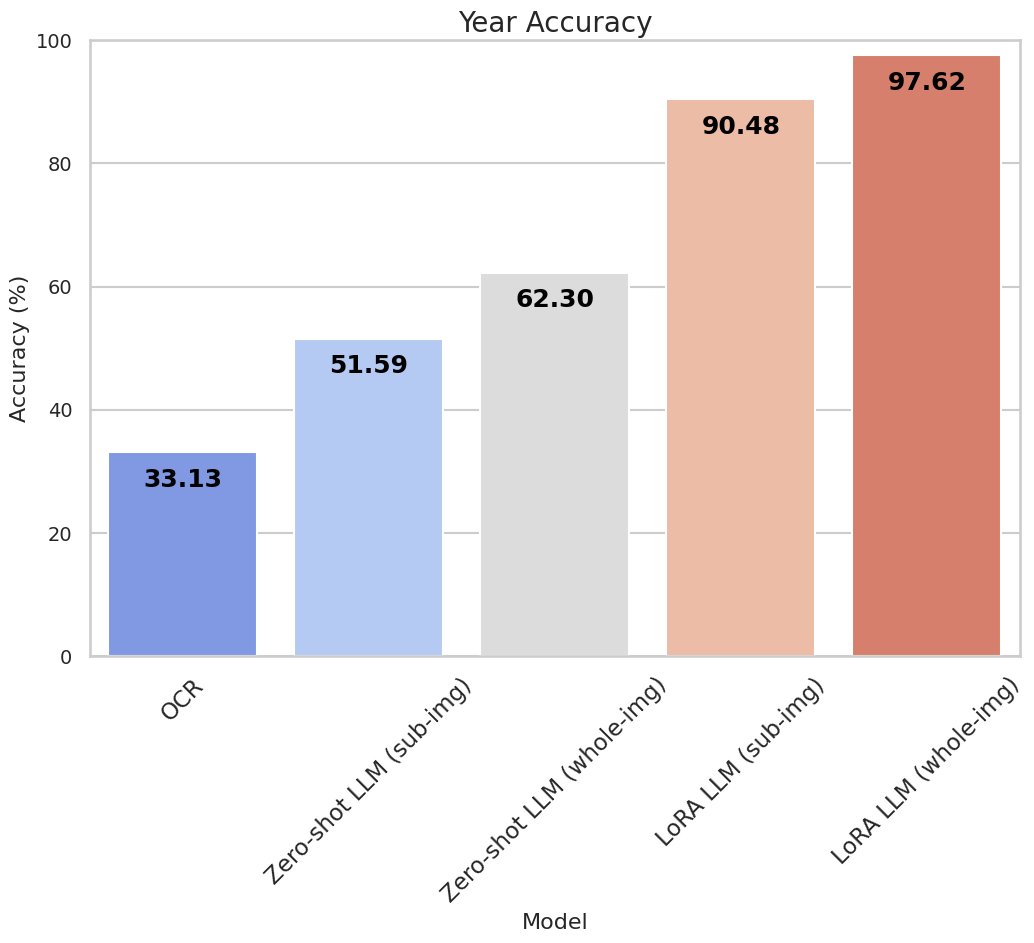

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


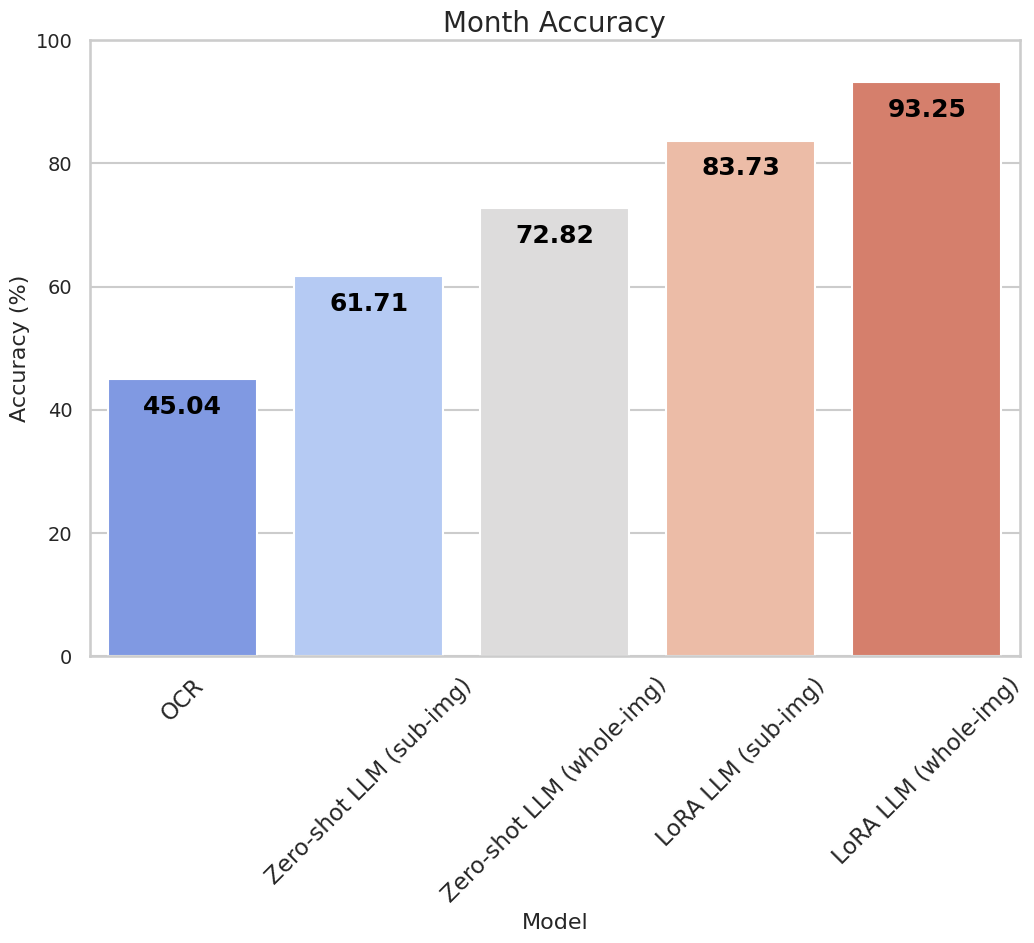

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


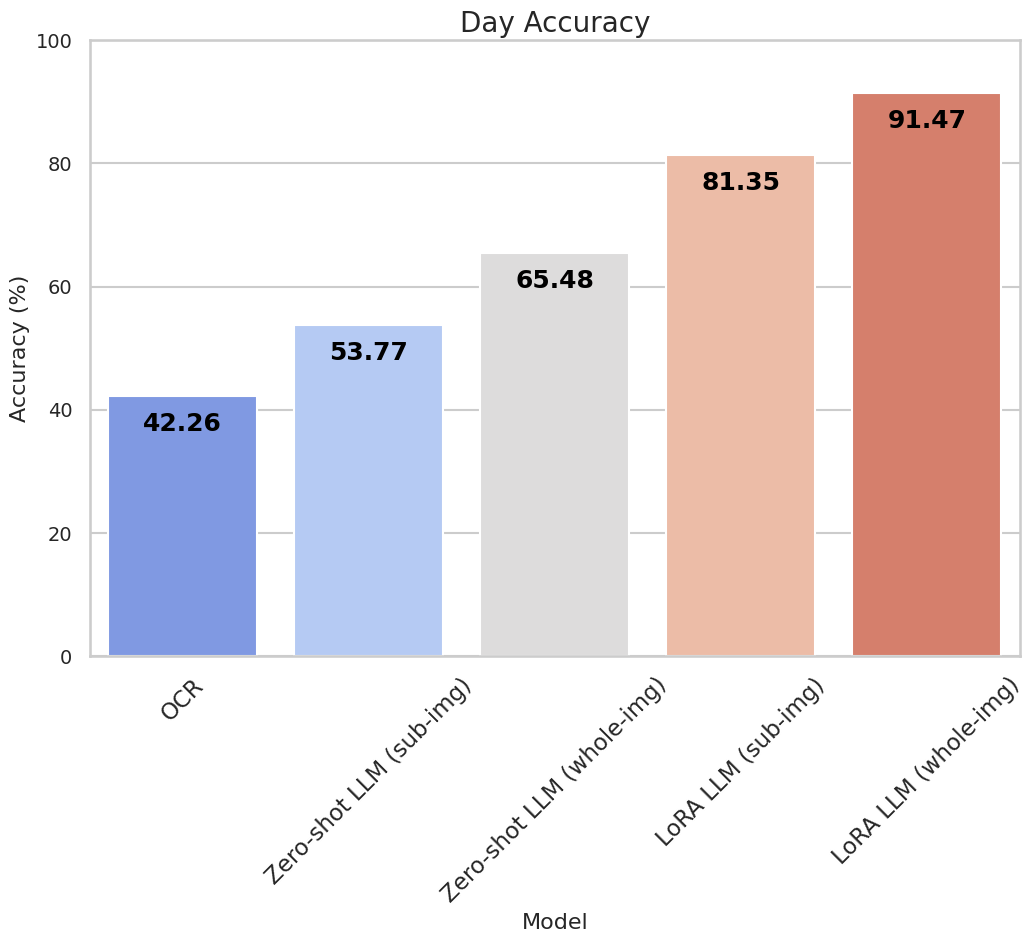

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


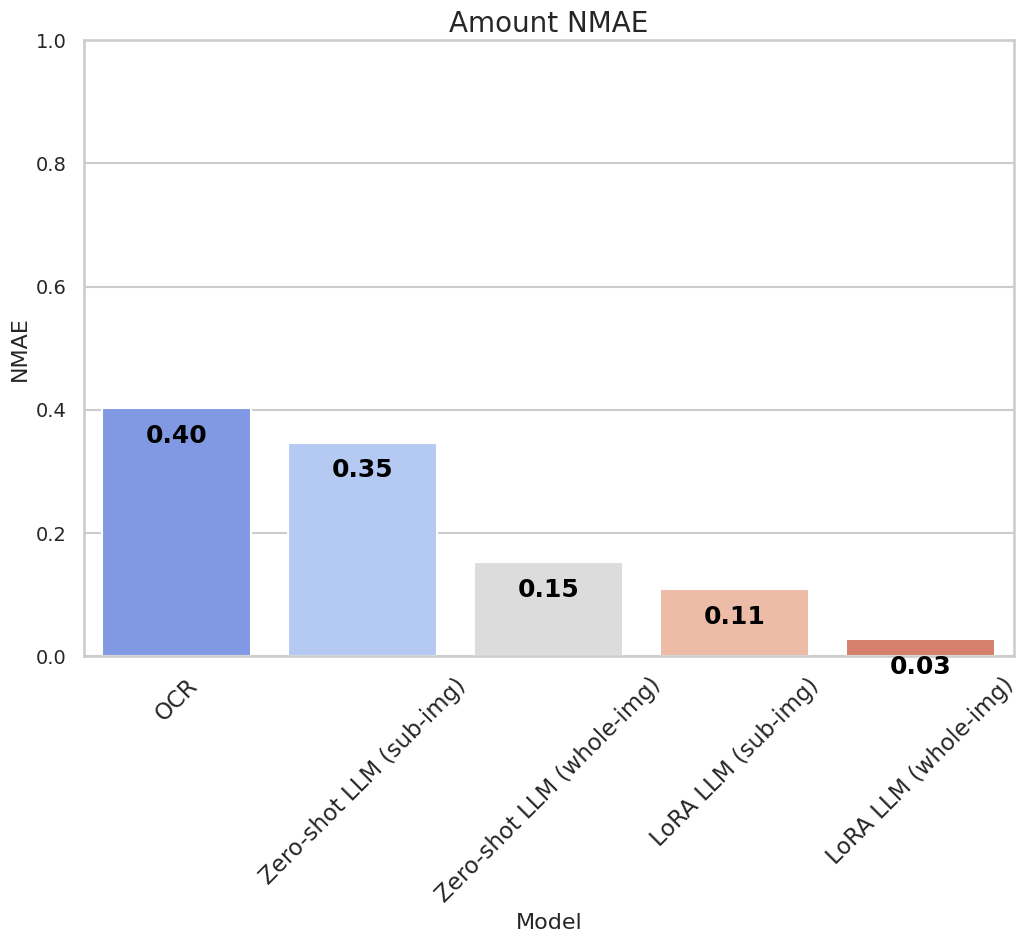

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


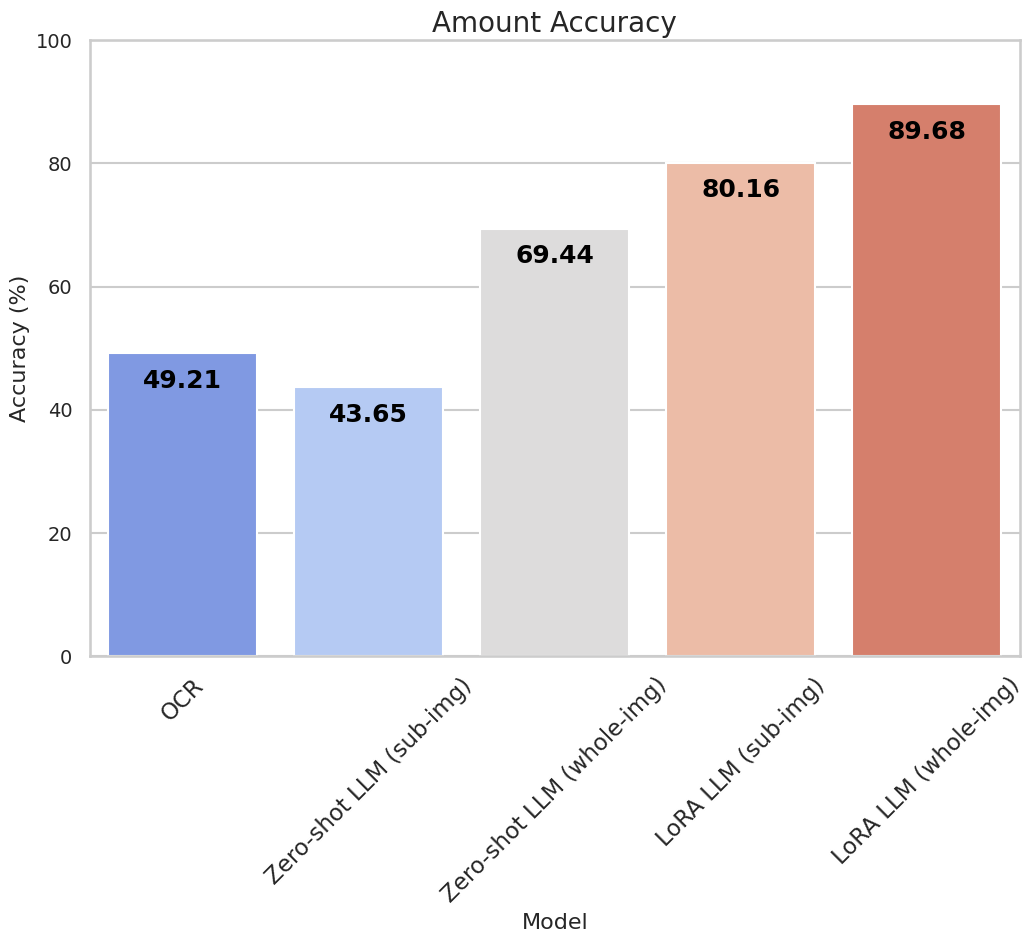

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


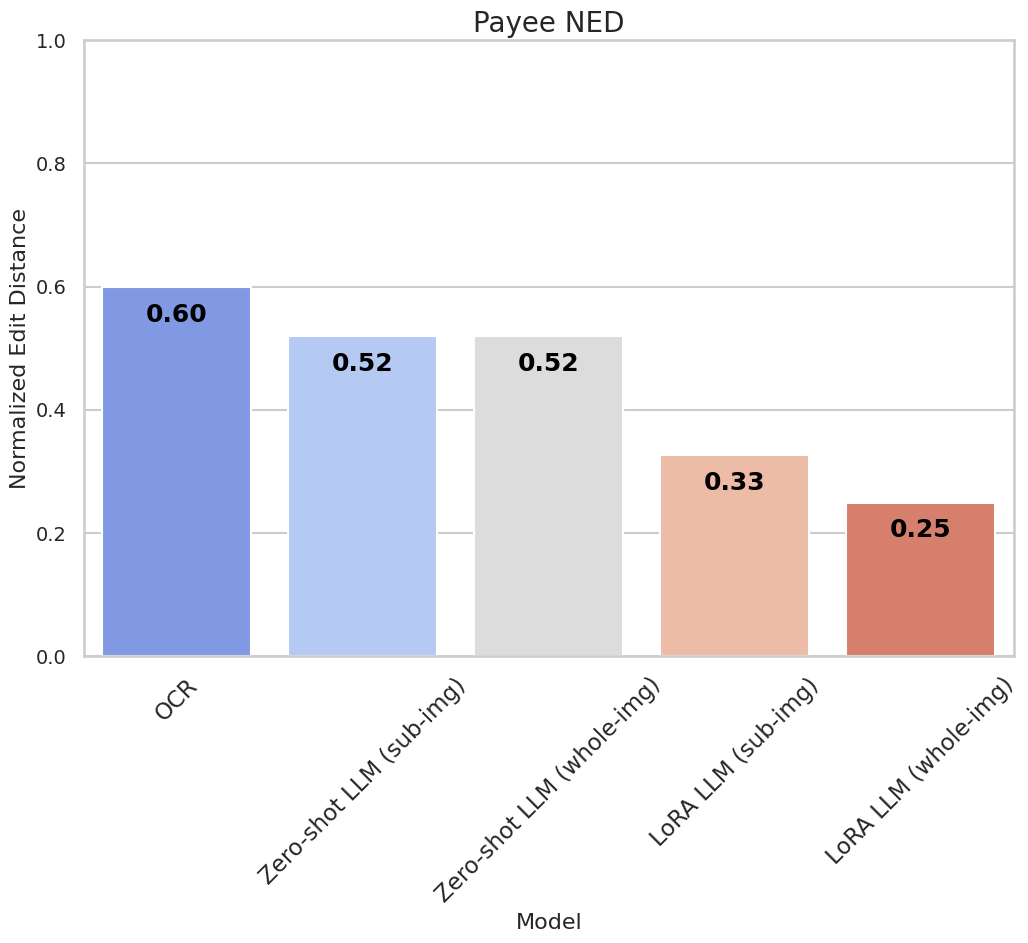

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


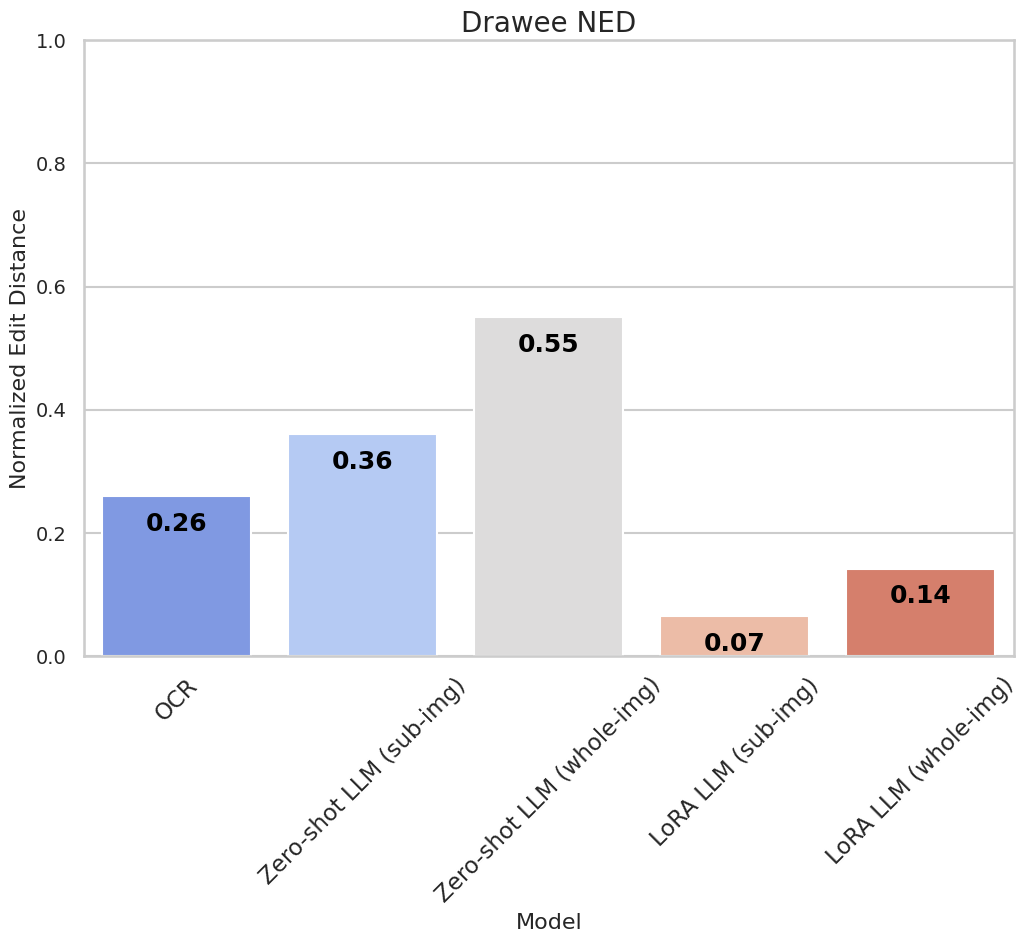

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


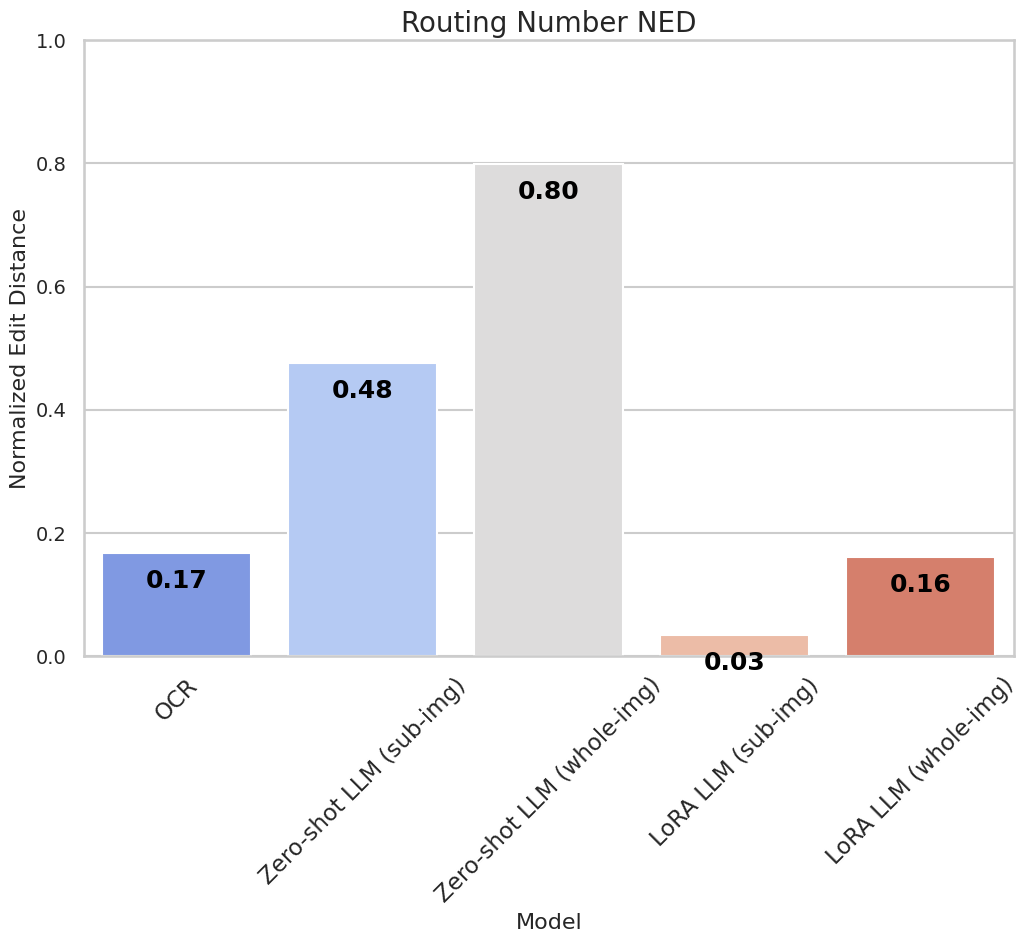

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


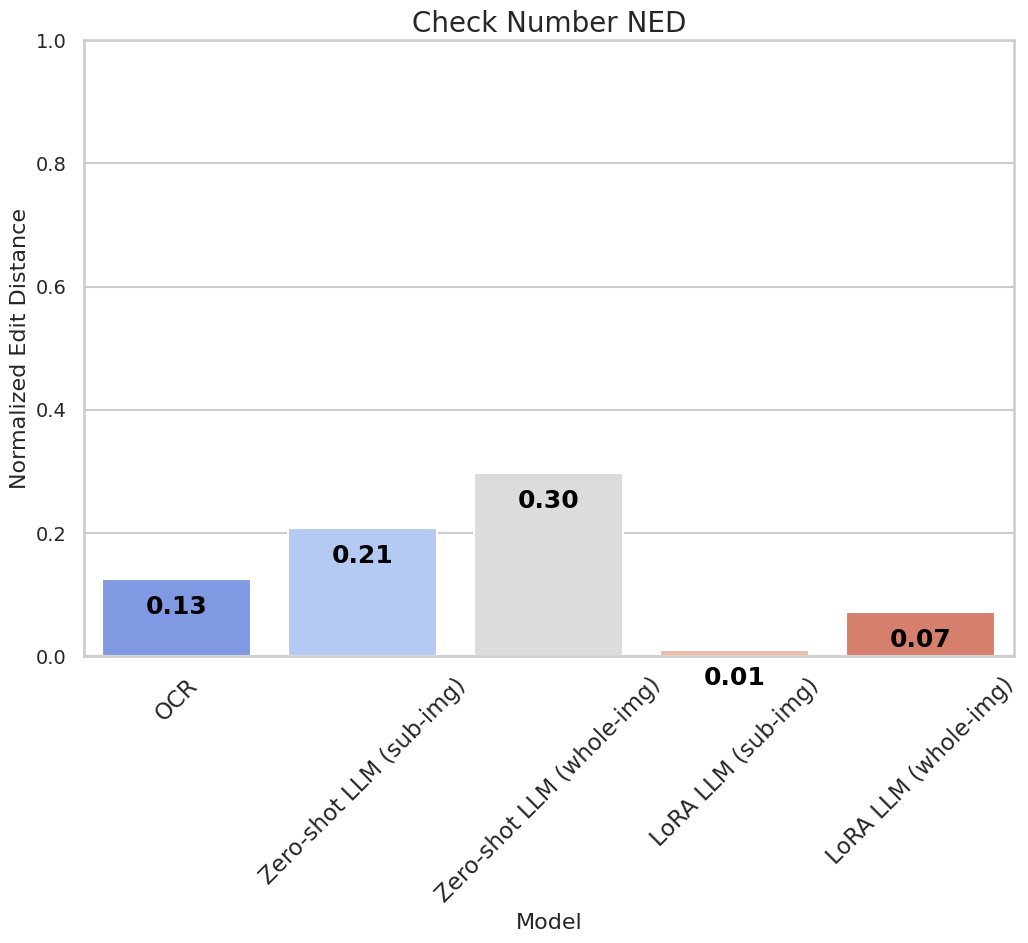

/tmp/ipykernel_3701052/2053222403.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')


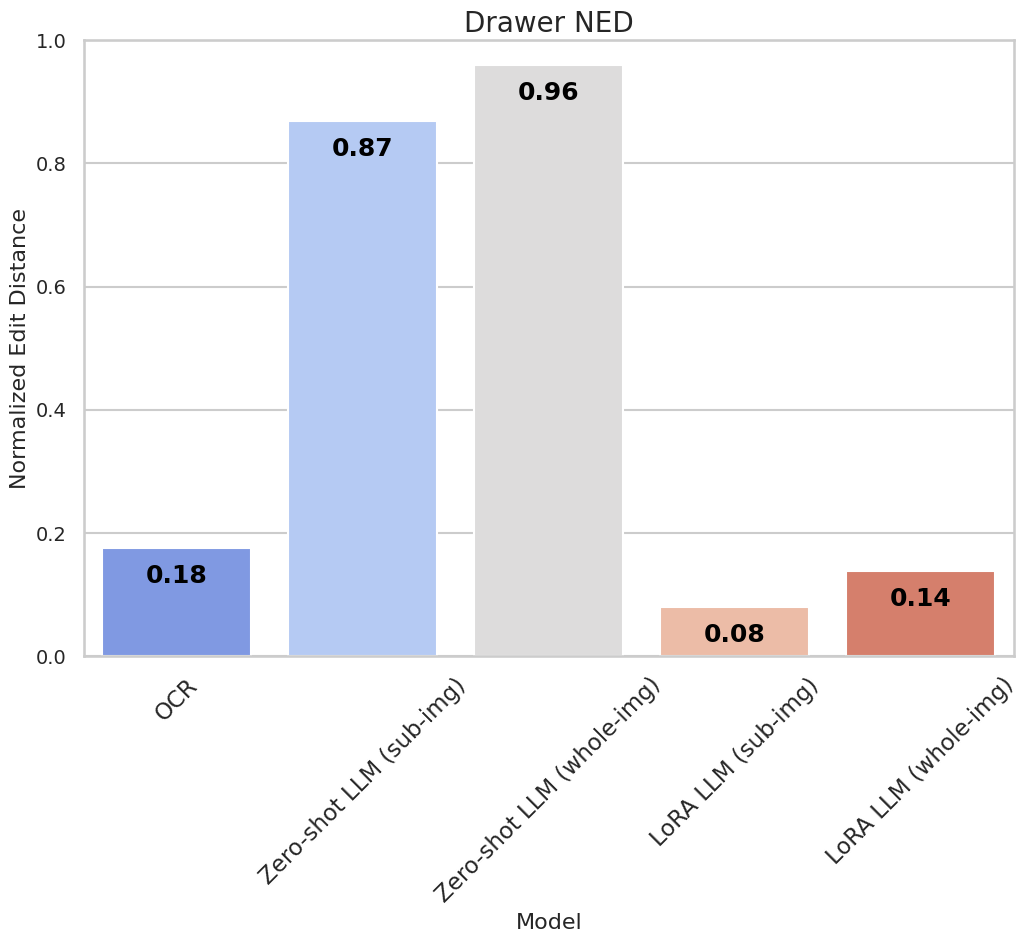

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model order
model_order = ['OCR', 'Zero-shot LLM (sub-img)', 'Zero-shot LLM (whole-img)', 'LoRA LLM (sub-img)', 'LoRA LLM (whole-img)']

# Date element accuracies
date_accuracy_data = {
    'Model': model_order,
    'Year Accuracy (%)': [33.13, 51.59, 62.30, 90.48, 97.62],
    'Month Accuracy (%)': [45.04, 61.71, 72.82, 83.73, 93.25],
    'Day Accuracy (%)': [42.26, 53.77, 65.48, 81.35, 91.47]
}
date_acc_df = pd.DataFrame(date_accuracy_data)

# Payee element normalized edit distances
payee_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.5994, 0.5199, 0.5194, 0.3260, 0.2494]
}
payee_ned_df = pd.DataFrame(payee_ned_data)

# Amount element NMAE and Accuracy
amount_data = {
    'Model': model_order,
    'NMAE': [0.4033, 0.3469, 0.1531, 0.1088, 0.0283],
    'Accuracy (%)': [49.21, 43.65, 69.44, 80.16, 89.68]
}
amount_df = pd.DataFrame(amount_data)

# Drawee element normalized edit distances
drawee_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.2599, 0.3609, 0.5503, 0.0659, 0.1425]
}
drawee_ned_df = pd.DataFrame(drawee_ned_data)

# Routing Number element normalized edit distances
routing_number_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1671, 0.4762, 0.7994, 0.0349, 0.1609]
}
routing_number_ned_df = pd.DataFrame(routing_number_ned_data)

# Check Number element normalized edit distances
check_number_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1255, 0.2083, 0.2969, 0.0096, 0.0724]
}
check_number_ned_df = pd.DataFrame(check_number_ned_data)

# Drawer element normalized edit distances
drawer_ned_data = {
    'Model': model_order,
    'Normalized Edit Distance': [0.1757, 0.8685, 0.9591, 0.0797, 0.1385]
}
drawer_ned_df = pd.DataFrame(drawer_ned_data)

# Setup Seaborn
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_context("talk")  # Larger fonts and figures for better readability

def plot_seaborn_metric(df, metric, title, ylabel, ylim=None):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Model', y=metric, data=df, palette='coolwarm')

    # Add text annotation slightly below the top of each bar
    for p in ax.patches:
        text_y = p.get_height() if p.get_height() > 0 else 0
        ax.annotate(format(text_y, '.2f'), 
                    (p.get_x() + p.get_width() / 2., text_y), 
                    ha='center', va='center', 
                    xytext=(0, -20),  # Negative value moves the text upward
                    textcoords='offset points',
                    color='black', 
                    weight='bold')

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Model', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(fontsize=14)
    if ylim:
        plt.ylim(ylim)
    plt.show()

# Plotting all metrics with annotations
plot_seaborn_metric(date_acc_df, 'Year Accuracy (%)', 'Year Accuracy', 'Accuracy (%)', ylim=(0, 100))
plot_seaborn_metric(date_acc_df, 'Month Accuracy (%)', 'Month Accuracy', 'Accuracy (%)', ylim=(0, 100))
plot_seaborn_metric(date_acc_df, 'Day Accuracy (%)', 'Day Accuracy', 'Accuracy (%)', ylim=(0, 100))
plot_seaborn_metric(amount_df, 'NMAE', 'Amount NMAE', 'NMAE', ylim=(0, 1))
plot_seaborn_metric(amount_df, 'Accuracy (%)', 'Amount Accuracy', 'Accuracy (%)', ylim=(0, 100))
plot_seaborn_metric(payee_ned_df, 'Normalized Edit Distance', 'Payee NED', 'Normalized Edit Distance', ylim=(0, 1))
plot_seaborn_metric(drawee_ned_df, 'Normalized Edit Distance', 'Drawee NED', 'Normalized Edit Distance', ylim=(0, 1))
plot_seaborn_metric(routing_number_ned_df, 'Normalized Edit Distance', 'Routing Number NED', 'Normalized Edit Distance', ylim=(0, 1))
plot_seaborn_metric(check_number_ned_df, 'Normalized Edit Distance', 'Check Number NED', 'Normalized Edit Distance', ylim=(0, 1))
plot_seaborn_metric(drawer_ned_df, 'Normalized Edit Distance', 'Drawer NED', 'Normalized Edit Distance', ylim=(0, 1))
